# Sajad Hosseini Najafabadi
# 400301997
# DL2022_HW4_P2:

In [ ]:
# instal needed package
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import urllib
import zipfile
from pycocotools.coco import COCO
import numpy as np 
import skimage.io as io
import matplotlib.pyplot as plt 
%matplotlib inline 
import nltk
nltk.download('punkt')
import pickle
import os
import os.path
from collections import Counter
import torch
import torch.utils.data as data
from PIL import Image
import numpy as np
from tqdm import tqdm
import random
import json
import sys
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
import math

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Download the coco dataset and all requirements.

clone cocoapi:

In [ ]:
# clone cocoapi
!git clone 'https://github.com/cocodataset/cocoapi.git'
# change direction to cocoapi
%cd /content/cocoapi

Cloning into 'cocoapi'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 28.12 MiB/s, done.
Resolving deltas: 100% (576/576), done.
/content/cocoapi


download annotations:

In [ ]:
# download address of annotations_trainval2014 and image_info_test2014:
annotations_trainval2014 = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip'
image_info_test2014 = 'http://images.cocodataset.org/annotations/image_info_test2014.zip'

# dowmload annotations_trainval2014 and image_info_test2014
urllib.request.urlretrieve(annotations_trainval2014 , filename = 'annotations_trainval2014.zip' )
urllib.request.urlretrieve(image_info_test2014 , filename= 'image_info_test2014.zip' )

# extract all zip data
with zipfile.ZipFile('annotations_trainval2014.zip' , 'r') as zip_ref:
  zip_ref.extractall( './'  )
  
with zipfile.ZipFile('image_info_test2014.zip' , 'r') as zip_ref:
  zip_ref.extractall( './'  )

# remove redundant files
!rm -r annotations_trainval2014.zip
!rm -r image_info_test2014.zip

download train, test and val images:

In [ ]:
train2014 = 'http://images.cocodataset.org/zips/train2014.zip'
test2014 = 'http://images.cocodataset.org/zips/test2014.zip'
#val2014 = 'http://images.cocodataset.org/zips/val2014.zip'

urllib.request.urlretrieve( train2014 , 'train2014' )
urllib.request.urlretrieve( test2014 , 'test2014' )
#urllib.request.urlretrieve( val2014 , 'val2014' )

('test2014', <http.client.HTTPMessage at 0x7f1c2f0b2190>)

In [ ]:
# extract all image zip files
with zipfile.ZipFile( 'train2014' , 'r' ) as zip_ref:
  zip_ref.extractall( 'images' )

with zipfile.ZipFile( 'test2014' , 'r' ) as zip_ref:
  zip_ref.extractall( 'images' )

# remove redundant files
!rm -r /content/cocoapi/train2014
!rm -r /content/cocoapi/test2014

# Display a random image with the corresponding annotation:

initialize COCO API:

I've done this exersise with the help of the following project:

Source: https://github.com/rammyram/image_captioning


In [ ]:
# change direction to annotations
%cd /content/cocoapi/annotations

# initialize COCO API for instance annotations
instances_annFile = 'instances_val2014.json'
coco = COCO(instances_annFile)

# initialize COCO API for caption annotations
captions_annFile = 'captions_val2014.json'
coco_caps = COCO(captions_annFile)

# get image ids 
ids = list(coco.anns.keys())

/content/cocoapi/annotations
loading annotations into memory...
Done (t=5.82s)
creating index...
index created!
loading annotations into memory...
Done (t=0.40s)
creating index...
index created!


Pick a random annotation id and display image of that annotation:

/content/cocoapi/annotations
Two people setting up a market stand with jars
Two man that appear to be placing a great deal of jars on a table.
People are presenting food on a table in the middle of ac ity.
Two people preparing tables for selling homemade goods.
Two people dressed warmly, standing at picnic tables.
/content/cocoapi


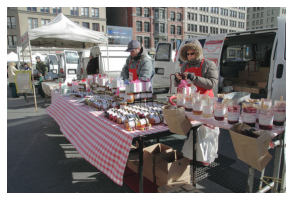

In [ ]:
%cd /content/cocoapi/annotations
ann_id = np.random.choice( ids )
img_id = coco.anns[ann_id]['image_id']
img = coco.loadImgs( img_id )[0]
url = img['coco_url']
I = io.imread(url)
plt.figure(figsize=[5,5])
plt.imshow(I)
plt.axis('off')

# Display captions for that annotation id :
ann_ids = coco_caps.getAnnIds( img_id   )
anns = coco_caps.loadAnns( ann_ids )
coco_caps.showAnns(anns)
%cd /content/cocoapi

# Create the proper vocabulary:

In [ ]:
class Vocabulary(object):

    def __init__(self,
        vocab_threshold,
        vocab_file='./vocab.pkl',
        start_word="<start>",
        end_word="<end>",
        unk_word="<unk>",
        annotations_file='../cocoapi/annotations/captions_train2014.json',
        vocab_from_file=False):
        """Initialize the vocabulary.
        Args:
          vocab_threshold: Minimum word count threshold.
          vocab_file: File containing the vocabulary.
          start_word: Special word denoting sentence start.
          end_word: Special word denoting sentence end.
          unk_word: Special word denoting unknown words.
          annotations_file: Path for train annotation file.
          vocab_from_file: If False, create vocab from scratch & override any existing vocab_file
                           If True, load vocab from from existing vocab_file, if it exists
        """
        self.vocab_threshold = vocab_threshold
        self.vocab_file = vocab_file
        self.start_word = start_word
        self.end_word = end_word
        self.unk_word = unk_word
        self.annotations_file = annotations_file
        self.vocab_from_file = vocab_from_file
        self.get_vocab()

    def get_vocab(self):
        """Load the vocabulary from file OR build the vocabulary from scratch."""
        if os.path.exists(self.vocab_file) & self.vocab_from_file:
            with open(self.vocab_file, 'rb') as f:
                vocab = pickle.load(f)
                self.word2idx = vocab.word2idx
                self.idx2word = vocab.idx2word
            print('Vocabulary successfully loaded from vocab.pkl file!')
        else:
            self.build_vocab()
            with open(self.vocab_file, 'wb') as f:
                pickle.dump(self, f)
        
    def build_vocab(self):
        """Populate the dictionaries for converting tokens to integers (and vice-versa)."""
        self.init_vocab()
        self.add_word(self.start_word)
        self.add_word(self.end_word)
        self.add_word(self.unk_word)
        self.add_captions()

    def init_vocab(self):
        """Initialize the dictionaries for converting tokens to integers (and vice-versa)."""
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        """Add a token to the vocabulary."""
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def add_captions(self):
        """Loop over training captions and add all tokens to the vocabulary that meet or exceed the threshold."""
        coco = COCO(self.annotations_file)
        counter = Counter()
        ids = coco.anns.keys()
        for i, id in enumerate(ids):
            caption = str(coco.anns[id]['caption'])
            tokens = nltk.tokenize.word_tokenize(caption.lower())
            counter.update(tokens)

            if i % 100000 == 0:
                print("[%d/%d] Tokenizing captions..." % (i, len(ids)))

        words = [word for word, cnt in counter.items() if cnt >= self.vocab_threshold]

        for i, word in enumerate(words):
            self.add_word(word)

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx[self.unk_word]
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

# Create the dataset:

In [ ]:
class CoCoDataset(data.Dataset):
    
    def __init__(self, transform, mode, batch_size, vocab_threshold, vocab_file, start_word, 
        end_word, unk_word, annotations_file, vocab_from_file, img_folder):
        self.transform = transform
        self.mode = mode
        self.batch_size = batch_size
        self.vocab = Vocabulary(vocab_threshold, vocab_file, start_word,
            end_word, unk_word, annotations_file, vocab_from_file)
        self.img_folder = img_folder
        if self.mode == 'train':            
            self.coco = COCO(annotations_file)
            self.ids = list(self.coco.anns.keys())
            print('Obtaining caption lengths...')
            all_tokens = [nltk.tokenize.word_tokenize(str(self.coco.anns[self.ids[index]]['caption']).lower()) for index in tqdm(np.arange(len(self.ids)))]
            self.caption_lengths = [len(token) for token in all_tokens]
        else:
            test_info = json.loads(open(annotations_file).read())
            self.paths = [item['file_name'] for item in test_info['images']]
        
    def __getitem__(self, index):
        # obtain image and caption if in training mode
        if self.mode == 'train':
            ann_id = self.ids[index]
            caption = self.coco.anns[ann_id]['caption']
            img_id = self.coco.anns[ann_id]['image_id']
            path = self.coco.loadImgs(img_id)[0]['file_name']

            # Convert image to tensor and pre-process using transform
            image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
            image = self.transform(image)

            # Convert caption to tensor of word ids.
            tokens = nltk.tokenize.word_tokenize(str(caption).lower())
            caption = []
            caption.append(self.vocab(self.vocab.start_word))
            caption.extend([self.vocab(token) for token in tokens])
            caption.append(self.vocab(self.vocab.end_word))
            caption = torch.Tensor(caption).long()

            # return pre-processed image and caption tensors
            return image, caption

        # obtain image if in test mode
        else:
            path = self.paths[index]

            # Convert image to tensor and pre-process using transform
            PIL_image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
            orig_image = np.array(PIL_image)
            image = self.transform(PIL_image)

            # return original image and pre-processed image tensor
            return orig_image, image

    def get_train_indices(self):
        sel_length = np.random.choice(self.caption_lengths)
        all_indices = np.where([self.caption_lengths[i] == sel_length for i in np.arange(len(self.caption_lengths))])[0]
        indices = list(np.random.choice(all_indices, size=self.batch_size))
        return indices

    def __len__(self):
        if self.mode == 'train':
            return len(self.ids)
        else:
            return len(self.paths)

# Create the Dataloader:

In [ ]:
def get_loader(transform,
               mode='train',
               batch_size=1,
               vocab_threshold=None,
               vocab_file='./vocab.pkl',
               start_word="<start>",
               end_word="<end>",
               unk_word="<unk>",
               vocab_from_file=True,
               num_workers=0,
               cocoapi_loc='/opt'):
    """Returns the data loader.
    Args:
      transform: Image transform.
      mode: One of 'train' or 'test'.
      batch_size: Batch size (if in testing mode, must have batch_size=1).
      vocab_threshold: Minimum word count threshold.
      vocab_file: File containing the vocabulary. 
      start_word: Special word denoting sentence start.
      end_word: Special word denoting sentence end.
      unk_word: Special word denoting unknown words.
      vocab_from_file: If False, create vocab from scratch & override any existing vocab_file.
                       If True, load vocab from from existing vocab_file, if it exists.
      num_workers: Number of subprocesses to use for data loading 
      cocoapi_loc: The location of the folder containing the COCO API: https://github.com/cocodataset/cocoapi
    """
    
    assert mode in ['train', 'test'], "mode must be one of 'train' or 'test'."
    if vocab_from_file==False: assert mode=='train', "To generate vocab from captions file, must be in training mode (mode='train')."

    # Based on mode (train, val, test), obtain img_folder and annotations_file.
    if mode == 'train':
        if vocab_from_file==True: assert os.path.exists(vocab_file), "vocab_file does not exist.  Change vocab_from_file to False to create vocab_file."
        img_folder = os.path.join(cocoapi_loc, 'cocoapi/images/train2014/')
        annotations_file = os.path.join(cocoapi_loc, 'cocoapi/annotations/captions_train2014.json')
    if mode == 'test':
        assert batch_size==1, "Please change batch_size to 1 if testing your model."
        assert os.path.exists(vocab_file), "Must first generate vocab.pkl from training data."
        assert vocab_from_file==True, "Change vocab_from_file to True."
        img_folder = os.path.join(cocoapi_loc, 'cocoapi/images/test2014/')
        annotations_file = os.path.join(cocoapi_loc, 'cocoapi/annotations/image_info_test2014.json')

    # COCO caption dataset.
    dataset = CoCoDataset(transform=transform,
                          mode=mode,
                          batch_size=batch_size,
                          vocab_threshold=vocab_threshold,
                          vocab_file=vocab_file,
                          start_word=start_word,
                          end_word=end_word,
                          unk_word=unk_word,
                          annotations_file=annotations_file,
                          vocab_from_file=vocab_from_file,
                          img_folder=img_folder)

    if mode == 'train':
        # Randomly sample a caption length, and sample indices with that length.
        indices = dataset.get_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        initial_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        # data loader for COCO dataset.
        data_loader = data.DataLoader(dataset=dataset, 
                                      num_workers=num_workers,
                                      batch_sampler=data.sampler.BatchSampler(sampler=initial_sampler,
                                                                              batch_size=dataset.batch_size,
                                                                              drop_last=False))
    else:
        data_loader = data.DataLoader(dataset=dataset,
                                      batch_size=dataset.batch_size,
                                      shuffle=True,
                                      num_workers=num_workers)

    return data_loader


In [ ]:

# Define a transform to pre-process the training images.
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Set the minimum word count threshold.
vocab_threshold = 8

# Specify the batch size.
batch_size = 200

# Obtain the data loader.
data_loader_train = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=False,
                         cocoapi_loc = '/content')

loading annotations into memory...
Done (t=0.78s)
creating index...
index created!
[0/414113] Tokenizing captions...
[100000/414113] Tokenizing captions...
[200000/414113] Tokenizing captions...
[300000/414113] Tokenizing captions...
[400000/414113] Tokenizing captions...
loading annotations into memory...
Done (t=0.56s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 414113/414113 [00:38<00:00, 10669.70it/s]


In [ ]:
# Exploring the dataloader now :

sample_caption = 'A person doing a trick xxxx on a rail while riding a skateboard.'
sample_tokens = nltk.tokenize.word_tokenize( sample_caption.lower() )

sample_caption = []
start_word  = data_loader_train.dataset.vocab.start_word
end_word = data_loader_train.dataset.vocab.end_word
sample_tokens.insert(0 , start_word)
sample_tokens.append(end_word)
sample_caption.extend( [ data_loader_train.dataset.vocab(token) for token in sample_tokens ] )


sample_caption = torch.Tensor( sample_caption ).long()
print('Find Below the Sample tokens and the idx values of those tokens in word2idx' , '\n')
print(sample_tokens) 
print(sample_caption )

print('Find index values for words below \n')
print('Start idx {} , End idx {} , unknown idx {}'.format( 0,1,2 ))

Find Below the Sample tokens and the idx values of those tokens in word2idx 

['<start>', 'a', 'person', 'doing', 'a', 'trick', 'xxxx', 'on', 'a', 'rail', 'while', 'riding', 'a', 'skateboard', '.', '<end>']
tensor([  0,   3,  97, 744,   3, 393,   2,  38,   3, 993, 205, 137,   3, 743,
         18,   1])
Find index values for words below 

Start idx 0 , End idx 1 , unknown idx 2


In [ ]:
# Lets check word2idx in vocb 
print('First few vocab' , dict(list(data_loader_train.dataset.vocab.word2idx.items())[:10]))
# Print the total number of keys in the word2idx dictionary.
print('Total number of tokens in vocabulary:', len(data_loader_train.dataset.vocab))

First few vocab {'<start>': 0, '<end>': 1, '<unk>': 2, 'a': 3, 'very': 4, 'clean': 5, 'and': 6, 'well': 7, 'decorated': 8, 'empty': 9}
Total number of tokens in vocabulary: 7072


# Use the Data Loader to Obtain Batches:

In [ ]:
counter = Counter(data_loader_train.dataset.caption_lengths)
lengths = sorted( counter.items() , key = lambda pair : pair[1] , reverse=True )
for val,count in lengths:
  print( 'value %2d  count %5d' %(val,count) )
  if count < 10000: 
    break

value 10  count 86302
value 11  count 79971
value  9  count 71920
value 12  count 57653
value 13  count 37668
value 14  count 22342
value  8  count 20742
value 15  count 12839
value 16  count  7736


In [ ]:
# Randomly sample a caption length, and sample indices with that length.
indices = data_loader_train.dataset.get_train_indices()
print('Sample Indices:' , indices )

# Create and assign a batch sampler to retrieve a batch with the sampled indices.
sampler = data.sampler.SubsetRandomSampler(  indices )
data_loader_train.batch_sampler.sampler = sampler 

# obtain images, caption :
images , captions = next(iter(data_loader_train))
print(images.shape , captions.shape)

Sample Indices: [184615, 376176, 378055, 302686, 165304, 381087, 25805, 23577, 166443, 6860, 173540, 47324, 368893, 349728, 232840, 2765, 16260, 187347, 195437, 11602, 137617, 381773, 176700, 178632, 289532, 227226, 262425, 153331, 350208, 30772, 393410, 293583, 303131, 314795, 413153, 404800, 108193, 254546, 227774, 219914, 126981, 218148, 96219, 79728, 128231, 321693, 233430, 344704, 93431, 67185, 108183, 25111, 137775, 390468, 125877, 187488, 345888, 323995, 156734, 365827, 30652, 165845, 181226, 218374, 294092, 311994, 260423, 371065, 350322, 29604, 226849, 327729, 87004, 282125, 3614, 249289, 152084, 300014, 255356, 102563, 278616, 163108, 356827, 256093, 330096, 217830, 190377, 311334, 40632, 17430, 99405, 346446, 49643, 178575, 259045, 257767, 32322, 149514, 101598, 79174, 185556, 29854, 67232, 106263, 225020, 386774, 255373, 279372, 353487, 292612, 222436, 382052, 72542, 168383, 156978, 333102, 27326, 413075, 154137, 219848, 232284, 286331, 107728, 69018, 153327, 178299, 12761,

# Encoder:
The encoder uses the pre-trained ResNet-50 architecture:

In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        features = self.resnet(images)        
        features = features.view(features.size(0), -1)        
        features = self.embed(features)        
        return features

In [ ]:
# specify dim of image embedding
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embed_size = 256 
encoder = EncoderCNN( embed_size )
encoder.to(device)
images=  images.to(device) # images from step2 
features = encoder(images)

print(type(features) , features.shape , images.shape)
assert( type(features) == torch.Tensor )  , 'Encoder output should be pytorch tensor'
assert (features.shape[0] == batch_size) & (features.shape[1] == embed_size) , "The shape of the encoder output is incorrect."

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

<class 'torch.Tensor'> torch.Size([200, 256]) torch.Size([200, 3, 224, 224])


# Decoder:

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super( DecoderRNN , self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size 
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        self.word_embedding = nn.Embedding( self.vocab_size , self.embed_size )
        self.lstm  = nn.LSTM(    input_size  =  self.embed_size , 
                             hidden_size = self.hidden_size,
                             num_layers  = self.num_layers ,
                             batch_first = True 
                             )
        self.fc = nn.Linear( self.hidden_size , self.vocab_size  )
        

    def init_hidden( self, batch_size ):
      return ( torch.zeros( self.num_layers , batch_size , self.hidden_size  ).to(device),
      torch.zeros( self.num_layers , batch_size , self.hidden_size  ).to(device) )
    
    def forward(self, features, captions):            
      captions = captions[:,:-1]      
      self.batch_size = features.shape[0]
      self.hidden = self.init_hidden( self.batch_size )
      embeds = self.word_embedding( captions )
      inputs = torch.cat( ( features.unsqueeze(dim=1) , embeds ) , dim =1  )      
      lstm_out , self.hidden = self.lstm(inputs , self.hidden)      
      outputs = self.fc( lstm_out )      
      return outputs

    def Predict(self, inputs, max_len=20):        
        final_output = []
        batch_size = inputs.shape[0]         
        hidden = self.init_hidden(batch_size) 
    
        while True:
            lstm_out, hidden = self.lstm(inputs, hidden) 
            outputs = self.fc(lstm_out)  
            outputs = outputs.squeeze(1) 
            _, max_idx = torch.max(outputs, dim=1) 
            final_output.append(max_idx.cpu().numpy()[0].item())             
            if (max_idx == 1 or len(final_output) >=20 ):
                break
            
            inputs = self.word_embedding(max_idx) 
            inputs = inputs.unsqueeze(1)             
        return final_output  

In [ ]:
embed_size = 256
hidden_size = 100
num_layers =1 
num_epochs = 1
print_every = 150
save_every = 1 
vocab_size = len(data_loader_train.dataset.vocab)
total_step = math.ceil( len(data_loader_train.dataset.caption_lengths) / data_loader_train.batch_sampler.batch_size   )


decoder = DecoderRNN(  embed_size , hidden_size, vocab_size ,num_layers)
criterion = nn.CrossEntropyLoss()
lr = 0.001
all_params = list(decoder.parameters())  + list( encoder.embed.parameters() )
optimizer = torch.optim.Adam( params  = all_params , lr = lr  )



device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_save_path = '/content/drive/My Drive/Colab Notebooks/ComputerVision/RNN_LSTM/image_caption/CVND---Image-Captioning-Project/checkpoint'
os.makedirs( model_save_path , exist_ok=True)

# Save the params needed to created the model :
decoder_input_params = {'embed_size' : embed_size , 
                'hidden_size' : hidden_size , 
                'num_layers' : num_layers,
                'lr' : lr ,
                'vocab_size' : vocab_size
                }

with open(  os.path.join(model_save_path , 'decoder_input_params_12_20_2019.pickle'), 'wb') as handle:
    pickle.dump(decoder_input_params, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
import sys 
for e in range(num_epochs):
  for step in range(total_step):
    indices = data_loader_train.dataset.get_train_indices()
    new_sampler = data.sampler.SubsetRandomSampler( indices )
    data_loader_train.batch_sampler.sampler = new_sampler    
    images,captions = next(iter(data_loader_train))    
    images , captions = images.to(device) , captions.to(device)
    encoder , decoder = encoder.to(device) , decoder.to(device)
    encoder.zero_grad()    
    decoder.zero_grad()
    features = encoder(images)
    output = decoder( features , captions )    
    loss = criterion( output.view(-1, vocab_size) , captions.view(-1) )
    loss.backward()
    optimizer.step()
    stat_vals = 'Epochs [%d/%d] Step [%d/%d] Loss [%.4f] ' %( e+1,num_epochs,step,total_step,loss.item() )
    if step % print_every == 0 :
      print(stat_vals)
      sys.stdout.flush()
    if e % save_every == 0:
      torch.save( encoder.state_dict() ,  os.path.join( model_save_path , 'encoderdata_{}.pkl'.format(e+1) ) )
      torch.save( decoder.state_dict() ,  os.path.join( model_save_path , 'decoderdata_{}.pkl'.format(e+1) ) )


Epochs [1/1] Step [0/2071] Loss [8.8714] 
Epochs [1/1] Step [150/2071] Loss [4.0912] 
Epochs [1/1] Step [300/2071] Loss [3.7415] 
Epochs [1/1] Step [450/2071] Loss [3.4262] 
Epochs [1/1] Step [600/2071] Loss [4.4484] 
Epochs [1/1] Step [750/2071] Loss [3.1337] 
Epochs [1/1] Step [900/2071] Loss [3.0758] 
Epochs [1/1] Step [1050/2071] Loss [3.6582] 
Epochs [1/1] Step [1200/2071] Loss [3.6251] 
Epochs [1/1] Step [1350/2071] Loss [2.9390] 
Epochs [1/1] Step [1500/2071] Loss [2.8122] 
Epochs [1/1] Step [1650/2071] Loss [3.1504] 
Epochs [1/1] Step [1800/2071] Loss [2.7180] 
Epochs [1/1] Step [1950/2071] Loss [2.7019] 


I've trained it for just 1 epoch due to the lack of GPU time resources.

In [ ]:
model_save_path = '/content/drive/My Drive/Colab Notebooks/ComputerVision/RNN_LSTM/image_caption/CVND---Image-Captioning-Project/checkpoint'
os.makedirs( model_save_path , exist_ok=True)

device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#with open(  os.path.join(model_save_path , 'decoder_input_params_12_19_2019.pickle'), 'rb') as handle:
#    decoder_input_params = pickle.load(handle)

embed_size = decoder_input_params['embed_size']
hidden_size= decoder_input_params['hidden_size']
vocab_size = decoder_input_params['vocab_size']
num_layers = decoder_input_params['num_layers']

encoder = EncoderCNN( embed_size )
encoder.load_state_dict(   torch.load(  os.path.join( model_save_path , 'encoderdata_{}.pkl'.format(1) )   ) )

decoder = DecoderRNN( embed_size , hidden_size , vocab_size , num_layers )
decoder.load_state_dict( torch.load(   os.path.join( model_save_path , 'decoderdata_{}.pkl'.format(1) )   ) )


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [ ]:
# Define a transform to pre-process the training images.
transform_test = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Obtain the data loader.
data_loader_test = get_loader(transform=transform_test,
                         mode='test',                         
                         cocoapi_loc = '/content')

data_iter = iter(data_loader_test)

Vocabulary successfully loaded from vocab.pkl file!


In [ ]:
def get_sentences( original_img, all_predictions ):
  sentence = ' '
  plt.imshow(original_img.squeeze())
  return sentence.join([data_loader_test.dataset.vocab.idx2word[idx] for idx in all_predictions[1:-1] ]  )

'a man is standing on a skateboard .'

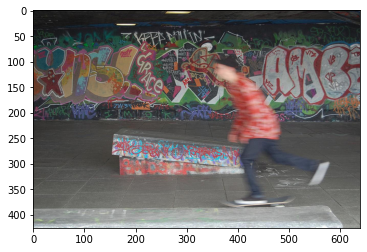

In [ ]:
encoder.to(device) 
decoder.to(device)
encoder.eval()
decoder.eval()
original_img , processed_img  = next( data_iter )

features  = encoder(processed_img.to(device)   ).unsqueeze(1)
final_output = decoder.Predict( features  , max_len=20)
get_sentences(original_img, final_output)